In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
PATH_TO_IMDB = r'C:\Users\sgs4176\Jupyter\aclImdb'
reviews_train = load_files(os.path.join(PATH_TO_IMDB, 'train'), categories=['pos', 'neg'])
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, 'test'), categories=['pos', 'neg'])
text_test, y_test = reviews_test.data, reviews_test.target

In [12]:
np.bincount(y_train), np.bincount(y_test)

(array([12500, 12500], dtype=int64), array([12500, 12500], dtype=int64))

In [13]:
cv = CountVectorizer()
cv.fit(text_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [15]:
len(cv.vocabulary_)

74849

In [19]:
print(cv.get_feature_names()[0:50], cv.get_feature_names()[5000:5050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m'] ['augustine', 'augusto', 'augustus', 'auh', 'auie', 'auld', 'aulin', 'aulis', 'aumont', 'aunt', 'auntie', 'aunties', 'aunts', 'aunty', 'aur', 'aura', 'aural', 'aurally', 'auras', 'aured', 'aurelius', 'aurora', 'auroras', 'aurthur', 'aus', 'auschwitz', 'auscrit', 'auspices', 'auspicious', 'auspiciously', 'aussi', 'aussie', 'aussies', 'austen', 'austeniana', 'austens', 'auster', 'austere', 'austerity', 'austin', 'austinese', 'austion', 'austrailan', 'austrailia', 'austrailian', 'australia', 'australian', 'australians', 'australlian', 'austreheim']


In [20]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

In [21]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562])

In [22]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562]))

In [23]:
text_train[19726]

b'This movie is terrible but it has some good effects.'

In [26]:
X_train[19726].data

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [27]:
X_test = cv.transform(text_test)

In [28]:
%%time
logit = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=17)
logit.fit(X_train, y_train)

Wall time: 3.6 s


In [30]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3)

(0.981, 0.864)

In [52]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ['red' if c<0 else 'blue' for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha='right')

In [72]:
def plot_grid_scores(grid, param_name):
    print(grid.cv_results_)
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'], color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'], color='red', label='test')
    plt.legend()

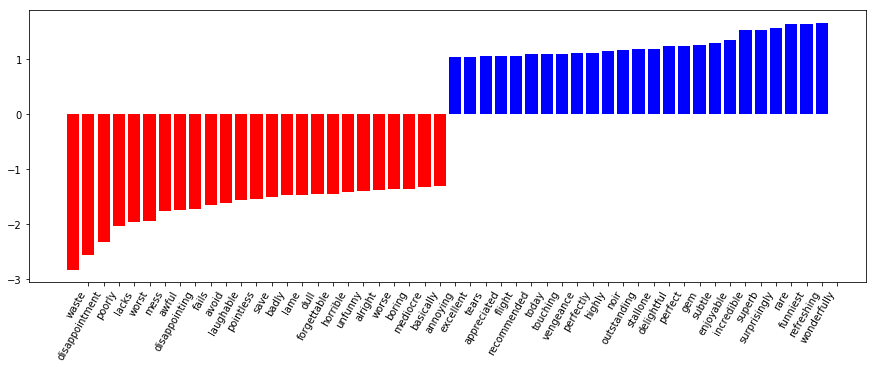

In [57]:
visualize_coefficients(logit, cv.get_feature_names())

In [61]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), LogisticRegression(solver='lbfgs', n_jobs=1, random_state=17))
text_pipe_logit.fit(text_train, y_train)

Wall time: 6.75 s


In [62]:
print(text_pipe_logit.score(text_test, y_test))

0.86396


In [66]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)
grid_logit.fit(text_train, y_train)

Wall time: 58.3 s


In [67]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.88484)

{'mean_fit_time': array([4.07444247, 4.14957372, 4.85402417, 6.75527477, 6.35434659,
       5.75428335]), 'std_fit_time': array([0.0348957 , 0.05805332, 0.14261797, 0.09428646, 0.59199723,
       0.86862144]), 'mean_score_time': array([1.5624884 , 1.64959002, 1.7336998 , 1.61933764, 1.84905728,
       1.49932551]), 'std_score_time': array([0.05155599, 0.11121336, 0.24165596, 0.15260694, 0.13142903,
       0.06912771]), 'param_logisticregression__C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'logisticregression__C': 1e-05}, {'logisticregression__C': 0.0001}, {'logisticregression__C': 0.001}, {'logisticregression__C': 0.01}, {'logisticregression__C': 0.1}, {'logisticregression__C': 1.0}], 'split0_test_score': array([0.68442525, 0.75533957, 0.84017279, 0.87712983, 0.88720902,
       0.88024958]), 'split1_test_score': array([0.6737461 , 0.76685865, 0.8

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


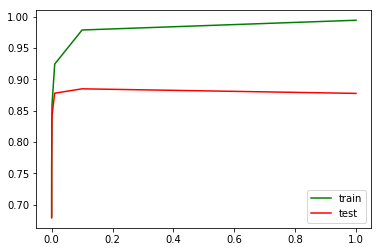

In [73]:
plot_grid_scores(grid_logit, 'logisticregression__C')

In [69]:
grid_logit.score(text_test, y_test)

0.87812

Now let's do the same with random forest. We see that, with logistic regression, we achieve better accuracy with less effort.

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [77]:
%%time
forest.fit(X_train, y_train)

Wall time: 53 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [78]:
round(forest.score(X_test, y_test), 3)

0.855

XOR-Problem

In [89]:
import matplotlib as mlp
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

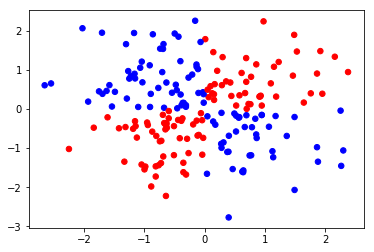

In [90]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=mlp.colors.ListedColormap(['r', 'b']))

In [94]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
    clf.fit(X, y)
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)
    
    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12)

D:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
D:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


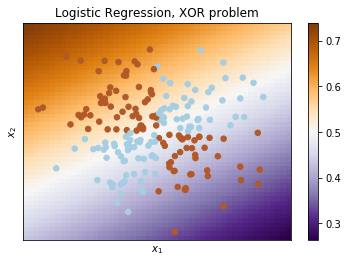

In [95]:
plot_boundary(LogisticRegression(), X, y,
              "Logistic Regression, XOR problem")

In [96]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

D:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
D:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


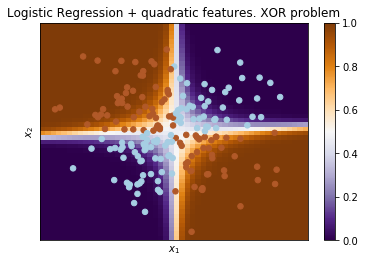

In [97]:
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression())])

plot_boundary(logit_pipe, X, y,
              "Logistic Regression + quadratic features. XOR problem")